In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import denoise_tv_bregman
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
#Load the data.
train = pd.read_json("input/train.json")

In [3]:
test = pd.read_json("input/test.json")

In [4]:
X_band_1=np.array([np.array(band).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).reshape(75, 75) for band in train["band_2"]])

X_band_1=np.array([np.array(band).astype(np.float32) for band in X_band_1])
X_band_2=np.array([np.array(band).astype(np.float32) for band in X_band_2])

X_band_1=np.array([band-band.mean() for band in X_band_1])
X_band_2=np.array([band-band.mean() for band in X_band_2])

X_band_1=np.array([band/band.std() for band in X_band_1])
X_band_2=np.array([band/band.std() for band in X_band_2])

In [5]:
#X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)
X_train2 = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis]], axis=-1)
target_train=train['is_iceberg']

In [40]:
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(all_train_soft, all_target_soft, random_state=1, train_size=0.85)

C:\Anaconda3\envs\tfgpu\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [41]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import keras.regularizers as reg
import time

In [42]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [43]:
def getModel():
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3,3), input_shape=(75,75,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, kernel_size=(2, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(64, kernel_size=(2,2), input_shape=(75,75,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    #model.add(Dropout(0.7))
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    #model.add(Dropout(0.7))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.00015)
    #mypotim=SGD(lr=0.001,decay=1e-4, momentum=0.9,nesterov=True)
    
    model.compile(loss='binary_crossentropy', optimizer = mypotim, metrics=['accuracy'])

    model.summary()
    return model


In [44]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='wrap')
datagen.fit(X_train_cv)

C:\Anaconda3\envs\tfgpu\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (8523, 75, 75, 2) (2 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


In [45]:
import os
gmodel=getModel()
batch_size = 32
ts = str(int(time.time()))
file_path = ".model_weights_generator"+ts+".hdf5"
gmodel.fit_generator(datagen.flow(X_train_cv, y_train_cv, batch_size=batch_size),
                    steps_per_epoch=len(X_train_cv) / batch_size,
                    epochs=200,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=get_callbacks(filepath=file_path, patience=200))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 73, 73, 64)        1216      
_________________________________________________________________
activation_8 (Activation)    (None, 73, 73, 64)        0         

C:\Anaconda3\envs\tfgpu\lib\site-packages\keras\preprocessing\image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (8523, 75, 75, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')



_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
activation_9 (Activation)    (None, 34, 34, 128)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       65664     
_________________________________________________________________
activation_10 (Activation)   (None, 16, 16, 128)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_8 

KeyboardInterrupt: 

In [12]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_train_cv, y_train_cv, verbose=1)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

224/241 [==========================>...] - ETA: 0sTest loss: 0.171234453862
Test accuracy: 0.941908718145
1248/1363 [==========================>...] - ETA: 0sTrain loss: 0.177453759394
Train accuracy: 0.933969185707


In [13]:
gmodel.save('model_train_all_1712.h5')

In [14]:
X_band_test_1=np.array([np.array(band).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).reshape(75, 75) for band in test["band_2"]])

X_band_test_1=np.array([np.array(band).astype(np.float32) for band in X_band_test_1])
X_band_test_2=np.array([np.array(band).astype(np.float32) for band in X_band_test_2])

X_band_test_1=np.array([band-band.mean() for band in X_band_test_1])
X_band_test_2=np.array([band-band.mean() for band in X_band_test_2])

X_band_test_1=np.array([band/band.std() for band in X_band_test_1])
X_band_test_2=np.array([band/band.std() for band in X_band_test_2])

X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis], X_band_test_2[:, :, :, np.newaxis]], axis=-1)

In [15]:
predicted_test=gmodel.predict_proba(X_test)

8352/8424 [============================>.] - ETA: 0s

In [16]:
predicted_test_s = pd.DataFrame(predicted_test).iloc[:,0]

In [17]:
strong_predicted_test_s = predicted_test_s[(predicted_test_s>0.99) | (predicted_test_s<0.001)]

In [18]:
strong_predicted_X_test = X_test[strong_predicted_test_s.index.values]

In [19]:
strong_predicted_test_s[predicted_test_s>0.99]=1
strong_predicted_test_s[predicted_test_s<0.001]=0

In [15]:
pseudo_labels_df=pd.DataFrame(gmodel.predict_classes(X_test))

8256/8424 [============================>.] - ETA: 0s

In [20]:
all_target = strong_predicted_test_s.append(target_train, ignore_index=True)

In [21]:
all_train = np.concatenate((strong_predicted_X_test,X_train2),axis=0)

In [36]:
all_target_soft = predicted_test_s.append(target_train, ignore_index=True)

In [37]:
all_train_soft = np.concatenate((X_test,X_train2),axis=0)

In [39]:
all_target_soft.shape

(10028,)

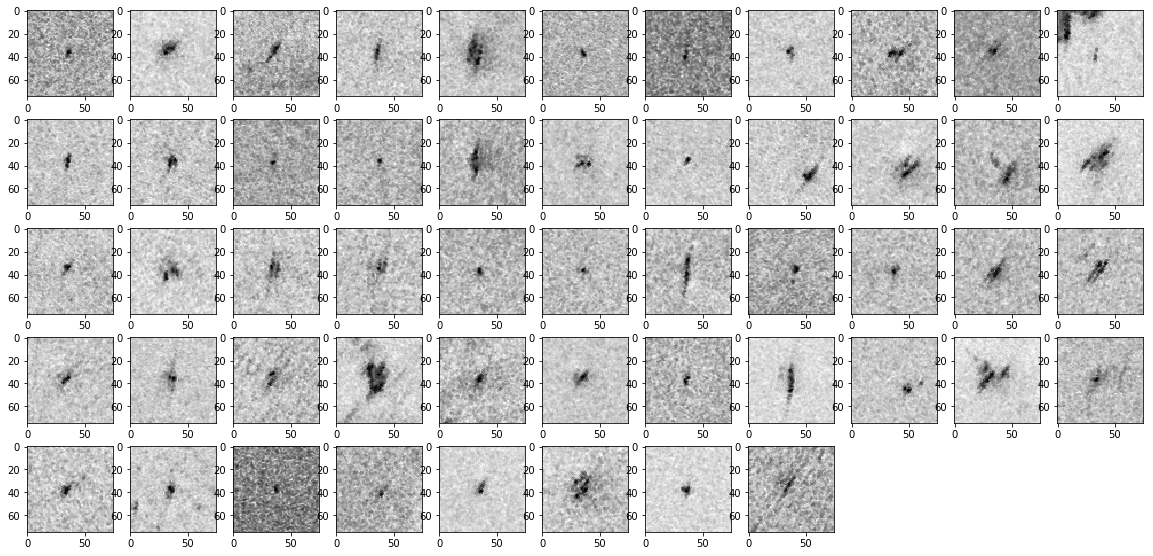

In [35]:
fig = plt.figure(200, figsize=(20, 200))
j=1
for i in range(0,100):
    if(target_train.iloc[i]==1):
        ax = fig.add_subplot(100, 11, j)
        ax.imshow(X_train2[i,:,:,0],cmap='Greys')
        j+=1
plt.show()

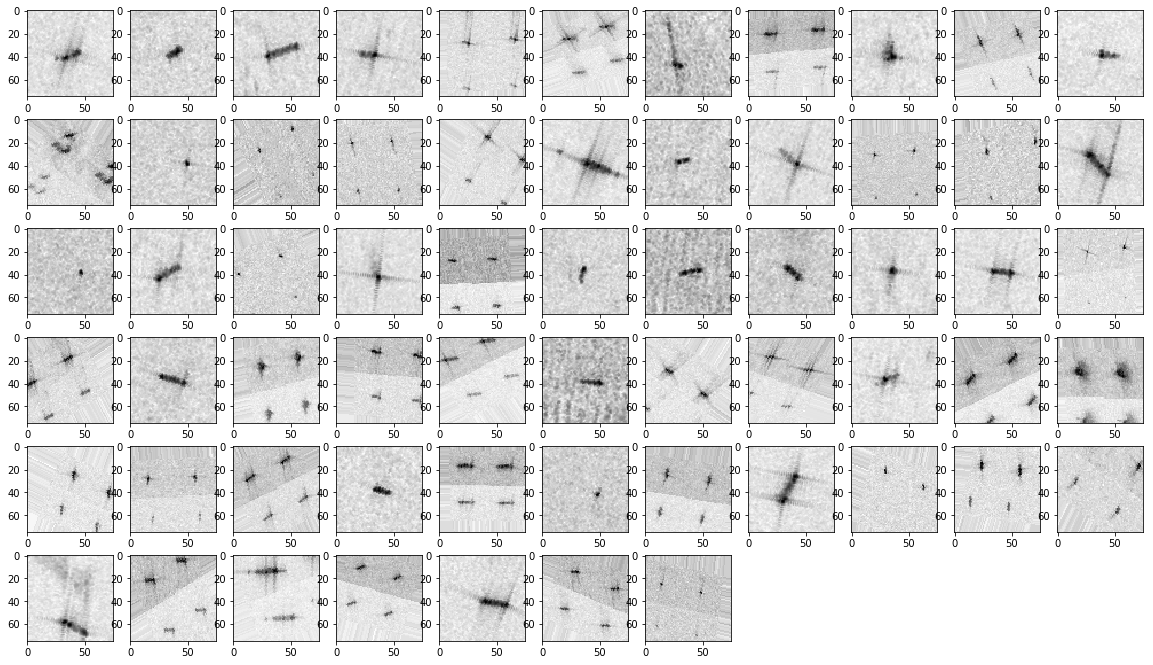

In [31]:
fig = plt.figure(200, figsize=(20, 200))
j=1
for i in range(0,100):
    if(strong_predicted_test_s.iloc[i]==0):
        ax = fig.add_subplot(100, 11, j)
        ax.imshow(strong_predicted_X_test[i,:,:,0],cmap='Greys')
        j+=1
plt.show()

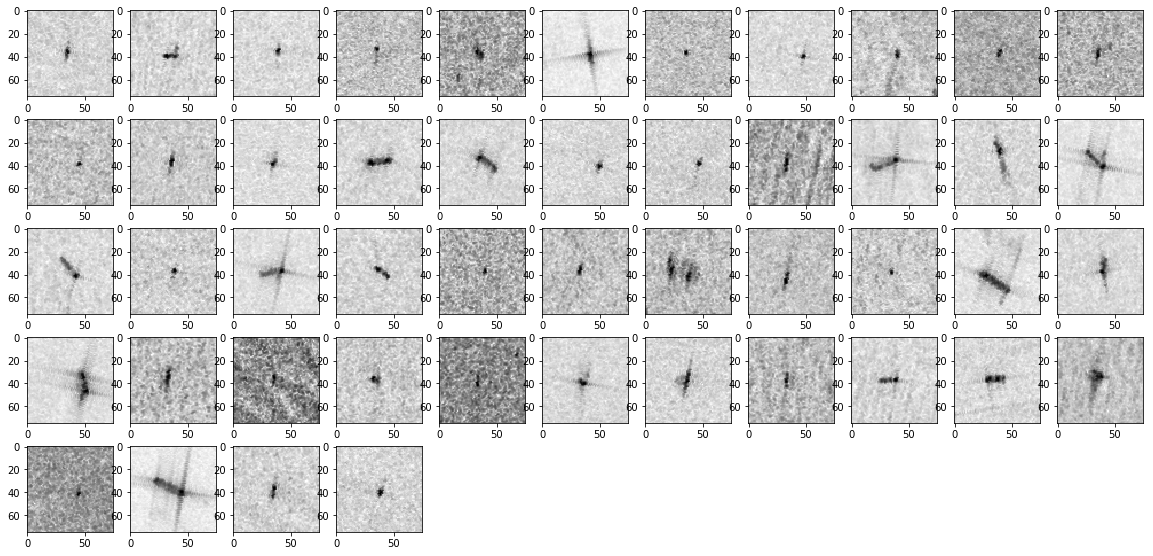

In [33]:
fig = plt.figure(200, figsize=(20, 200))
j=1
for i in range(0,100):
    if(target_train[i]==0):
        ax = fig.add_subplot(100, 11, j)
        ax.imshow(X_train2[i,:,:,0],cmap='Greys')
        j+=1
plt.show()

In [28]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)